#### Import as usual

In [1]:
import os
import datetime
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import miditok as midi
from functions import get_tokens, split_input_target, positional_encoding, masked_loss, masked_accuracy

In [2]:
%load_ext tensorboard

#### Get the tokens and some information about our data and some basic prep

smallest token:1.0, biggest token:499.0, number of unique tokens:(495,), missing tokens:{0, 178, 180, 182, 186}
number of tokens: 1820490
number of pieces: 295
average tokens per piece: 6171.152542372882


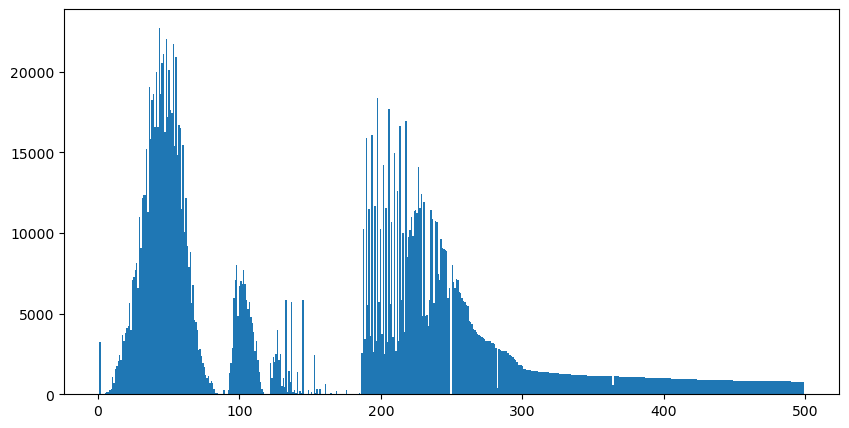

In [3]:
tokens, piece_counter = get_tokens() # get all tokens from the dataset
unique_tokens, count = np.unique(tokens, return_counts=True)
vocab_size = int(np.max(tokens)) + 1 # get the size of the vocabulary

print("smallest token:{}, biggest token:{}, number of unique tokens:{}, missing tokens:{}".format(np.min(tokens),np.max(tokens),np.unique(tokens).shape,set(range(0, 500))-set(tokens))) # print some information about the tokens
print("number of tokens: {}".format(len(tokens))) # print the number of tokens
print("number of pieces: {}".format(piece_counter)) # print the number of pieces
print("average tokens per piece: {}".format(len(tokens)/piece_counter)) # print average tokens per piece

# plot the distribution of the tokens
plt.figure(figsize=(10, 5))
plt.hist(tokens, bins=500)
plt.show()


data = tf.cast(tokens, tf.int32) # put tokens into a tensor and cast to int32
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n] # first 90% of data
val_data = data[n:] # last 10% of data

In [ ]:
'''
# postional encoding function
def positional_encoding(length, d_model):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(seq_length, d_model)

# plot the positional encoding
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()
'''


#### Transformer via subclassing

In [16]:
# layer for embedding and positional encoding
class PostionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, block_size, dropout_rate):
        super(PostionalEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.block_size = block_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, 
                          output_dim=d_model, # each token gets a 512-vector embedding
                          input_length=block_size)
        self.pos_encoding = positional_encoding(block_size, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    @tf.function
    def call(self, x):
        x = self.embedding(x) + self.pos_encoding[:, :self.block_size, :]
        x = self.dropout(x)
        return x
    
# dot-product attention
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super(ScaledDotProductAttention, self).__init__()
        self.head_size = d_model // n_heads
        self.key = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.query = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.value = tf.keras.layers.Dense(units=self.head_size, use_bias=False)

    @tf.function
    def call(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute scores
        scores = tf.matmul(q,tf.transpose(k, perm=[0, 2, 1])) / tf.math.sqrt(tf.cast(self.head_size, tf.float32))
        tril = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
        scores = tf.where(tril == 0, tf.fill(tril.shape, -float('inf')), scores)
        scores = tf.nn.softmax(scores, axis=-1)
        # weighted sum of values
        v = self.value(x)
        return tf.matmul(scores, v)

# multi-head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads,):
        super(MultiHeadAttention, self).__init__()
        self.heads = [ScaledDotProductAttention(d_model, n_heads) for _ in range(n_heads)]
        self.dense = tf.keras.layers.Dense(units=d_model, use_bias=False)
    
    @tf.function
    def call(self, x):
        x = tf.concat([head(x) for head in self.heads], axis=-1)
        x = self.dense(x)
        return x
    
# feed-forward network
class FeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=dff, activation=tf.nn.gelu)
        self.dense2 = tf.keras.layers.Dense(units=d_model)

    @tf.function
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# implementaion of SwiGLUFFN
class SwiGLUFFN(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(SwiGLUFFN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=(dff//3)*2, activation=tf.nn.silu, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(units=(dff//3)*2, use_bias=False)
        self.dense3 = tf.keras.layers.Dense(units=d_model, use_bias=False)

    @tf.function
    def call(self, x):
        w = self.dense1(x)
        v = self.dense2(x)
        x = self.dense3(w*v)
        return x

# decoder layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ffn = SwiGLUFFN(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.add = tf.keras.layers.Add()
    
    @tf.function
    def call(self, x):
        res_x = x
        x = self.layernorm(x)
        x = self.mha(x)
        x = self.dropout(x)
        x = self.add([res_x, x])
        res_x = x
        x = self.layernorm(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = self.add([res_x, x])
        return x
    
# decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Decoder, self).__init__()
        self.embedding = PostionalEmbedding(vocab_size, d_model, block_size, dropout_rate)
        self.layers = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]

    
    @tf.function
    def call(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return x
    
# transformer
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Transformer, self).__init__()
        self.decoder = Decoder(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size)
        self.final_dense = tf.keras.layers.Dense(units=vocab_size)
    
    @tf.function
    def call(self, x):
        x = self.decoder(x)
        logits = self.final_dense(x)
            
        try:      
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        return logits
    
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### Hyperparams

In [5]:
d_model = 192 # also embedding size
dff = 768 # inner feedforward layer dim
n_heads = 8 # number of heads in the multihead attention layer
d_v, d_q, d_k = d_model // n_heads , d_model // n_heads , d_model // n_heads # dimension of the query, key and value vectors 
n_layers = 6 # number of layers
dropout_rate = 0.1 # dropout rate
epochs = 100
seq_length = 4096 # length of the sequence
batch_size = 32 # batch size

In [17]:
# create the model with the specified parameters 
model = Transformer(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, seq_length)

model.build(input_shape=(None, seq_length))

# model.load_weights('dmodel 128 dff 512 nheads 8 nlayers 6 dropout 0.1 epochs 100 seqlen 512 batch 64.h5')



Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)
Tensor("mul_1:0", shape=(None, 4096, 512), dtype=float32)


In [19]:
model(tf.random.uniform((1, seq_length)))

<tf.Tensor: shape=(1, 4096, 500), dtype=float32, numpy=
array([[[ 0.93109655,  1.524544  ,  5.3054953 , ...,  1.8020641 ,
          0.5517999 ,  4.177929  ],
        [ 1.1230563 ,  1.1251721 ,  4.8477774 , ...,  1.7613504 ,
          0.3038156 ,  3.9153748 ],
        [ 1.3480986 ,  0.45306554,  4.3155565 , ...,  1.2198333 ,
          0.2016418 ,  3.7194157 ],
        ...,
        [-0.17362699,  0.73992664, -0.7337722 , ..., -0.52947897,
          1.1504998 , -2.7702982 ],
        [-0.14890286,  0.3638735 , -1.107051  , ..., -0.5768866 ,
          1.188055  , -2.6961622 ],
        [-0.15275988,  0.02487998, -0.9826255 , ..., -0.6566417 ,
          1.1292102 , -2.3084042 ]]], dtype=float32)>

In [18]:
l = SwiGLUFFN(d_model, dff)
l(tf.random.uniform((1, seq_length)))

Tensor("mul_1:0", shape=(1, 512), dtype=float32)
Tensor("mul_1:0", shape=(1, 512), dtype=float32)


<tf.Tensor: shape=(1, 192), dtype=float32, numpy=
array([[-0.30143425, -0.16266592,  0.13922173,  0.38900506, -0.3960744 ,
         0.24347688, -0.1372642 , -0.00229743,  0.15368676,  0.71757644,
        -0.23209517,  0.3859207 ,  0.03606668, -0.538191  ,  0.0056992 ,
         0.41539985, -0.01221757, -0.37797865, -0.01549714, -0.09799986,
        -0.20575377,  0.29777956, -0.06646045, -0.13448471, -0.31992278,
         0.3548094 , -0.16118677, -0.2725544 ,  0.5411022 , -0.3572122 ,
        -0.28140196,  0.5274282 ,  0.03013147,  0.6052353 , -0.2469005 ,
         0.48191392,  0.2865448 ,  0.06642406, -0.1946268 ,  0.12518826,
         0.29608214,  0.5940161 ,  0.41078615, -0.0652066 ,  0.59065354,
         0.2323617 , -0.24860588, -0.20385401,  0.19536783,  0.5349349 ,
         0.1904856 , -0.59692186, -0.1420533 , -0.03597724, -0.19153205,
        -0.43292904, -0.14504431,  0.4378357 , -0.631899  , -0.2034197 ,
        -0.70258385,  0.28495514, -0.0980965 , -0.4907956 , -0.17711607,
 

In [ ]:
# create tf.data.Dataset objects for training and validation
train_ds, val_ds = tf.data.Dataset.from_tensor_slices(train_data), tf.data.Dataset.from_tensor_slices(val_data)
# generate sequences of length with .batch and then split the sequences into input and target
train_ds, val_ds = train_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target), val_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target) 
# shuffle, batch and prefetch as usual
train_ds, val_ds = make_batches(train_ds), make_batches(val_ds)

# set the learning rate to our creeted custom schedule
learning_rate = CustomSchedule(d_model)

# create the optimizer with the learning rate and the other parameters as specified in the paper
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

# create the model with the specified parameters 
model = Transformer(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, seq_length)

model.build(input_shape=(None, seq_length))

model.load_weights('dmodel 128 dff 512 nheads 8 nlayers 6 dropout 0.1 epochs 100 seqlen 512 batch 64.h5')

# save weights of the model after every epoch
checkpoint_path = "checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=model,
                            optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=None)

# compile the model with the masked loss and masked accuracy
model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

# train the model 
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# save the model
model.save_weights('dmodel:{} dff:{} nheads:{} nlayers:{} dropout:{} epochs:{} seqlen:{} batch:{}.h5'.format(d_model, dff, n_heads, n_layers, dropout_rate, epochs, seq_length, batch_size))


In [17]:
max_len = 512
start_token = tf.constant([[89] + [3] + [0] * (seq_length)], dtype=tf.int64)
np.delete(start_token, 0, 1)

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
max_len = 511
start_token = tf.constant([[89] + [0] * (seq_length - 1)], dtype=tf.int64)

def generate_tokens_greedy(model, start_token, max_len):
    for i in range(max_len):
        logits = model(start_token) # generate logits for the next token
        probs = tf.nn.softmax(logits, axis = -1) # get the probabilities 
        argmax = tf.argmax(probs, axis = -1) # get the token with the highest probability
        start_token_numpy = start_token.numpy() # convert the tensor to numpy array
        start_token_numpy[:, i+1] = argmax[:,i].numpy() # add the predicted token to the sequence
        start_token = tf.constant(start_token_numpy, dtype=tf.int64) # convert the numpy array to tensor
        if argmax[:,i].numpy() == 176: # stop when the end token is predicted
            break
    return start_token

def generate_tokens_sampling(model, start_token, max_len):
    for i in range(max_len):
        logits = model(start_token) # generate logits for the next token
        start_token_numpy = start_token.numpy() # convert the tensor to numpy array
        start_token_numpy[:, i+1] = tf.random.categorical(logits[:,i], num_samples=1).numpy() # sample a token from the logits and add it to the sequence
        start_token = tf.constant(start_token_numpy, dtype=tf.int64) # convert the numpy array to tensor
        if start_token_numpy[:, i+1] == 176: # stop when the end token is predicted
            break
    return start_token

sample_song = generate_tokens_sampling(model, start_token, max_len)
sample_song.numpy().shape

(1, 512)

In [10]:
from miditok import REMI, MIDITokenizer
tokenizer = REMI()
tokenizer.load_params('Dataset_tokenized_BPE/config.txt')
coverted = tokenizer(sample_song, [(0, False)])
coverted.dump('sample_song_sampling.mid')

In [113]:
from miditok import REMI, MIDITokenizer
from miditok.utils import get_midi_programs
from miditoolkit import MidiFile
from pathlib import Path
tokenizer = REMI()
cock = MidiFile('Final_Project/Dataset/chopin/chp_op18.mid')
schwanz = tokenizer(MidiFile('Final_Project/Dataset/chopin/chp_op31.mid'))
tokens = tokenizer(cock) 
coverted_back = tokenizer(tokens, [(0, False), (0, False)])

In [115]:
len(tokens)

2

In [66]:
def json_rdy(sample):
    sample = sample.numpy().tolist()[0]
    sample = {"tokens" : [sample,sample], "programs" : [[0, False],[0, False]]}
    with open('{}.json', 'w'.format(sample)) as fp:
        json.dump(json_rdy(sample), fp)    
    return sample

None


In [45]:
sample_song.numpy()

# covert numpy array to list
list = sample_song.numpy().tolist()[0]
[list]

fil = {"tokens" : [list,list], "programs" : [[0, False],[0, False]]}
fil

{'tokens': [[89,
   218,
   16,
   96,
   153,
   28,
   97,
   153,
   194,
   28,
   96,
   252,
   32,
   97,
   248,
   21,
   94,
   157,
   28,
   96,
   157,
   33,
   97,
   153,
   1,
   192,
   28,
   96,
   139,
   193,
   28,
   96,
   138,
   35,
   96,
   138,
   36,
   97,
   138,
   194,
   16,
   258,
   28,
   231,
   198,
   28,
   456,
   40,
   260,
   218,
   16,
   258,
   28,
   231,
   190,
   28,
   260,
   36,
   456,
   16,
   258,
   28,
   231,
   206,
   28,
   260,
   36,
   492,
   20,
   297,
   32,
   231,
   214,
   28,
   260,
   36,
   429,
   20,
   258,
   32,
   227,
   190,
   32,
   260,
   39,
   456,
   20,
   258,
   32,
   231,
   206,
   32,
   293,
   38,
   492,
   20,
   258,
   32,
   231,
   214,
   28,
   260,
   34,
   429,
   20,
   94,
   169,
   28,
   95,
   169,
   33,
   95,
   169,
   208,
   32,
   93,
   127,
   38,
   291,
   44,
   264,
   210,
   20,
   258,
   32,
   231,
   214,
   32,
   293,
   38,
   260,
   44,
  